In [44]:
'''
'''

In [68]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import gensim
from nltk.corpus import brown
from gensim.corpora import Dictionary
import scipy.sparse
import numpy as np
#from gensim.corpora.Dictionary import load_from_text, doc2bow
from pprint import pprint  # pretty-printer
from collections import defaultdict
from gensim import corpora
from gensim.corpora import MmCorpus
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()


In [69]:
# get datasets

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))

In [70]:
documents = dataset.data

len(documents)


11314

In [71]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [72]:
# Data Preprocessing
# remove the punctuations, numbers, and special characters 
# Remove shorter words because they usually don’t contain useful information.
# make all the text lowercase to nullify case sensitivity

# removing everything except alphabets`
news_df = pd.DataFrame({'document':documents})

news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())



In [73]:
'''
remove the stop-words from the text data as they are mostly clutter and hardly carry any information.
Stop-words are terms like ‘it’, ‘they’, ‘am’, ‘been’, ‘about’, ‘because’, ‘while’, etc.
tokenize the text, by splitting the string of text into individual tokens or words.
then put the tokens back together after removing the stop-words.

'''
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc



In [74]:
#Document-Term Matrix
# TfidfVectorizer to create a document-term matrix with 1,000 terms.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, max_df = 0.5, smooth_idf=True)
# keep top 1000 terms 

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # check shape of the document-term matrix



(11314, 1000)

In [75]:
# limit computation time and disc usage by using 1,000 words as features 
#Topic Modeling
#to represent each and every term and document as a vector. document-term matrix is decomposed into multiple matrices. 
#using sklearn’s TruncatedSVD to perform the task of matrix decomposition.
#try to have 20 topics for text data, specified the number of topics by using the n_components parameter



In [76]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)


20

In [77]:
#The components of svd_model are the topics, svd_model.components_.
#print a few most important words in each of the 20 topics.

terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
like
 
know
 
people
 
think
 
good
 
time
 
thanks
 
Topic 1: 
thanks
 
windows
 
card
 
drive
 
mail
 
file
 
advance
 
Topic 2: 
game
 
team
 
year
 
games
 
season
 
players
 
good
 
Topic 3: 
drive
 
scsi
 
disk
 
hard
 
card
 
drives
 
problem
 
Topic 4: 
windows
 
file
 
window
 
files
 
program
 
using
 
problem
 
Topic 5: 
government
 
chip
 
mail
 
space
 
information
 
encryption
 
data
 
Topic 6: 
like
 
bike
 
know
 
chip
 
sounds
 
looks
 
look
 
Topic 7: 
card
 
sale
 
video
 
offer
 
monitor
 
price
 
jesus
 
Topic 8: 
know
 
card
 
chip
 
video
 
government
 
people
 
clipper
 
Topic 9: 
good
 
know
 
time
 
bike
 
jesus
 
problem
 
work
 
Topic 10: 
think
 
chip
 
good
 
thanks
 
clipper
 
need
 
encryption
 
Topic 11: 
thanks
 
right
 
problem
 
good
 
bike
 
time
 
window
 
Topic 12: 
good
 
people
 
windows
 
know
 
file
 
sale
 
files
 
Topic 13: 
space
 
think
 
know
 
nasa
 
problem
 
year
 
israel
 
Topic 14: 
space
 
good
 
card
 
people
 
time
 
nas

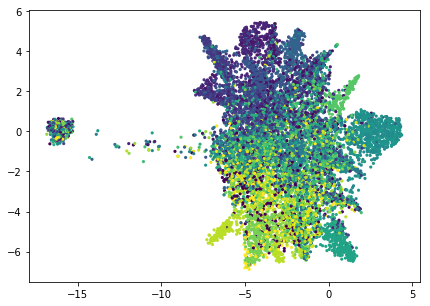

In [78]:
#Topics Visualization using umap

import umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1],c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()
 



In [79]:
# example LDA model

In [80]:
# 20newsgroups data
doc_complete = documents 

In [81]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]

In [82]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [83]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

In [84]:
# extracting sentiment from newsgroup data

In [85]:
from textblob import TextBlob

In [86]:
news_df['correct_doc'] = news_df['clean_doc'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [87]:
news_df['sentiment_doc'] = news_df['correct_doc'][:5].apply(lambda x: TextBlob(x).sentiment)

In [88]:
news_df['sentiment_doc'].head(3)  # tuple representing polarity and subjectivity 

0    (-0.04761904761904761, 0.5817460317460317)
1    (-0.09675925925925928, 0.5648148148148149)
2    (-0.12285714285714285, 0.3404761904761905)
Name: sentiment_doc, dtype: object